In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls '/content/drive/My Drive/Colab Notebooks/Wiley_self_citation'

new_self_citation_identification.ipynb	self_citation_identification.ipynb
raw_data


In [3]:
! pip install country_converter

     |████████████████████████████████| 51kB 4.4MB/s 
  Created wheel for country-converter: filename=country_converter-0.7.1-cp36-none-any.whl size=50807 sha256=f434f8ff4c8d25450395bf30a96e40351c2009c9a3499ed4af0b955ad791bcf7
  Stored in directory: /root/.cache/pip/wheels/75/be/cb/3c8d07bca8f2c0670e996a174fed372585b32d3aa03f40996a
Successfully built country-converter


In [4]:
! pip install pyspark

     |████████████████████████████████| 204.2MB 70kB/s 
     |████████████████████████████████| 204kB 49.3MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=96adbd7ced5cd02a2fa99101289f28b76e8e6a48354cf5e7cc76fd56faa7b7e7
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [5]:
import os
from itertools import product
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from multiprocessing import Pool, Manager
import country_converter as coco
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from IPython.display import display 
import time
from collections import defaultdict, OrderedDict
from statistics import median
import uuid
from pyspark.sql import SparkSession 
import logging
logging.disable(logging.WARNING)


In [6]:
class self_citation():
    
    def __init__(self, path):
        self.path = path
        self.read = False
        self.names = set()
        self.files = os.listdir(self.path)
        self.countrymap = {}
        self.created_spark = False
        
    def __parse_author(self, line):
        author = line.lower().replace('au','').strip().replace(',','')
        self.names.add(author)
            
        return author
    
    
    def __parse_citation(self, line):
        cited = line.lower().replace('cr','').strip().split(',',1)[0]
        self.names.add(cited)
        return cited
    
    
    def __parse_year(self, line):
        return int(line.replace('PY ',''))
    
    
    def __parse_location(self, line):
        return line.lower().strip()
    
    
    def __parse_authorcountry(self, line, authormap):
        authors = line[line.find('[')+1: line.find(']')]
        authors = authors.split(';')
        country = line.split(',')[-1].replace('.','').strip()
        for a in authors:
            a = a.strip()
            if a in authormap:
                self.countrymap[authormap[a]] = country
            else:
                pass
        return
        
    
    def __parse_country(self, country, to='ISO3'):
        country = country.replace('.','').strip()
        c = coco.convert(country, to=to)
        if c == 'not found': # handle USA
            c = coco.convert(country.split(' ')[-1], to=to)
        if c == 'not found': # england/scotland
            c = 'GBR'
        return c
    
    
    def __parse_title(self, line):
        return line.replace('TI','').lower().strip()
        
    
    def __parse_line(self, line, au, af, c1, cr, pa, py, er, ti, 
                     author_af_list, author_list, citation_list, year, location, title):
        
        if line.startswith('PT'):
            au = False
            af = False
            cr = False
            py = False
            er = False
            c1 = False
            ti = False
            author_list = []
            author_af_list = []
            citation_list = []
            year = None
            location = []
            title = []
            
        elif line.startswith('AU'):
            au = True
        elif line.startswith('AF'):
            au = False
            af = True
            
        elif line.startswith('C1'):
            c1 = True
        elif line.startswith('RP'):
            c1 = False
            
        elif line.startswith('CR'):
            cr = True
        elif line.startswith('NR'):
            cr = False
            
        elif line.startswith('PA'):
            pa = True
        elif line.startswith('SN'):
            pa = False
            
        elif line.startswith('PY'):
            py = True
        elif line.startswith('ER'):
            er = True
        
        elif line.startswith('TI'):
            ti = True
        elif line.startswith('SO'):
            ti = False
            
            
        if au:
            author = self.__parse_author(line)
            author_list.append(author)
        
        if af:
            author_af_list.append(line.replace('AF','').strip())
            if (len(author_list) == len(author_af_list)):
                af = False
        if cr:
            cited = self.__parse_citation(line)
            citation_list.append(cited)
            
        if c1:
            afauthormap = {author_af_list[i]:author_list[i] for i in range(len(author_list))}
            self.__parse_authorcountry(line, afauthormap)
            
        if line.startswith('PY'):
            year = self.__parse_year(line)
                    
        if ti:
            title.append(self.__parse_title(line))
        
        if pa:
            location.append(self.__parse_location(line))
            
        
        article_info = [author_list, citation_list, year, location, title]
        
        return au, af, c1, cr, pa, py, er, ti, author_af_list, article_info

    
    
    def article_info_from_text(self,to_folder):

        self.files = [f for f in self.files if '.txt' in f]
        self.to_folder = to_folder
        try: 
          os.mkdir(to_folder)
        except: pass
        
        au = False
        af = False
        c1 = False
        cr = False
        pa = False
        py = False
        er = False
        ti = False
        author_list = []
        author_af_list = []
        citation_list = []
        year = None
        location = []
        title = []
        
        start = time.time()

        af = open(self.to_folder+'article_fact.csv','a')
        colnames = 'article_id,title,year,country\n'
        af.write(colnames)
        af.close()

        cf = open(self.to_folder+'citation_fact.csv','a')
        colnames = 'article_id,author_id,cited_id\n'
        cf.write(colnames)
        cf.close()

        for file in self.files:
            text = open(self.path+file)
            for line in text:
                au, af, c1, cr, pa, py, er, ti, author_af_list, article_info = self.__parse_line(line, au, af,c1, cr,
                                                                                             pa, py, er, ti,
                                                                                             author_af_list, 
                                                                                             author_list, 
                                                                                             citation_list, 
                                                                                             year, 
                                                                                             location,
                                                                                             title)
                author_list, citation_list, year, location, title = article_info
                if er and py:
                    loc = ' '.join(location)
                    if loc.split(' ')[-1].strip() in ['states','republic']:
                        loc = loc.split(',')[-1].strip()
                    else:
                        loc = loc.split(' ')[-1].strip()
                                        
                    title = ' '.join(title)
                    title = title.replace(',','')
                    article_id = uuid.uuid5(uuid.NAMESPACE_DNS, title)
                    article_info = str(article_id) + ',' + title + ',' + str(year) + ',' + str(loc)
                    af = open(self.to_folder+'article_fact.csv','a')
                    af.write(article_info)
                    af.write('\n')
                    af.close()
                    
                    citations = list(product(author_list,citation_list))
                    cf = open(self.to_folder+'citation_fact.csv','a')
                    for citation in citations:
                        author = uuid.uuid5(uuid.NAMESPACE_DNS, citation[0])
                        cited = uuid.uuid5(uuid.NAMESPACE_DNS, citation[1])
                        cit = str(article_id) + ',' + str(author) + ',' + str(cited)
                        cf.write(cit)
                        cf.write('\n')
                    cf.close()
                    
                    
                    er = False
        auf = open(self.to_folder+'author_fact.csv','a')
        colnames = 'author_id,author_name,country\n'
        auf.write(colnames)
        for author in self.names:
            author_id = uuid.uuid5(uuid.NAMESPACE_DNS, author)
            try:
                author_country = self.countrymap[author]
            except:
                author_country = 'None'
            author_info = str(author_id) + ',' + author + ',' + author_country
            auf.write(author_info)
            auf.write('\n')
        
        auf.close()
        
        af = pd.read_csv(self.to_folder+'article_fact.csv',header=0)
        auf = pd.read_csv(self.to_folder+'author_fact.csv',header=0)
        old_countries = list(set(af['country'].to_list()).union(set(auf['country'].to_list())))
        iso3_countries = map(lambda x: self.__parse_country(x,'ISO3'),old_countries)
        cm = open(self.to_folder+'country_mapping.csv','a')
        colnames = 'country,iso3\n'
        cm.write(colnames)
        for old, iso3 in zip(old_countries,iso3_countries):
            cm.write(old+','+iso3)
            cm.write('\n')
        cm.close()
        
        end = time.time()            
        self.read = True
        print(end-start)


    def __create_spark_df(self):
        self.spark = SparkSession\
                    .builder\
                    .appName('abc')\
                    .getOrCreate()
        self.saf = self.spark.read.csv(self.to_folder+'article_fact.csv',header=True)
        self.sauf = self.spark.read.csv(self.to_folder+'author_fact.csv',header=True)
        self.scf = self.spark.read.csv(self.to_folder+'citation_fact.csv',header=True)
        self.scm = self.spark.read.csv(self.to_folder+'country_mapping.csv',header=True)


    def __create_temp_review(self):
        self.__create_spark_df()
        self.saf.createOrReplaceTempView('article_fact')
        self.sauf.createOrReplaceTempView('author_fact')
        self.scf.createOrReplaceTempView('citation_fact')
        self.scm.createOrReplaceTempView('country_mapping')
        self.created_spark = True

      
    def __by_author_location(self):
        if not self.created_spark:
            self.__create_temp_review()

        query = """
        select cm.iso3 country_id, auf.author_id, count(*) self_citation_level
        from citation_fact cf
        left join author_fact auf on cf.author_id = auf.author_id
        left join country_mapping cm on auf.country = cm.country
        where cf.author_id = cf.cited_id
        group by 1,2
        """

        df = self.spark.sql(query).toPandas().groupby('country_id').self_citation_level.median().sort_values(ascending=False).reset_index()
        df['country_name']=df['country_id'].apply(self.__parse_country,args=('name_short',))
        return df


    def plot_by_author_location(self):
        df = self.__by_author_location()
        display(df)
        fig = go.Figure(data=go.Choropleth(
            locations = df.country_id,
            z = df.self_citation_level,
            text = df.country_name,
            colorscale = 'Reds',
            autocolorscale=False,
            reversescale=False,
            marker_line_color='gray',
            marker_line_width=0.1,
            colorbar_title = 'self citation rate',),
            layout=dict(title = 'Self Citation Level by Author Location'))
        fig.show()
        return df, fig              

      
    def __by_publication_location(self):
        if not self.created_spark:
            self.__create_temp_review()

        query = """
        select cm.iso3 country_id, cf.author_id, count(*) self_citation_level
        from citation_fact cf
        left join article_fact af on cf.article_id = af.article_id
        left join country_mapping cm on af.country = cm.country
        where cf.author_id = cf.cited_id
        group by 1,2
        """

        df = self.spark.sql(query).toPandas().groupby('country_id').self_citation_level.median().sort_values(ascending=False).reset_index()
        df['country_name']=df['country_id'].apply(self.__parse_country,args=('name_short',))
        return df


    def plot_by_publication_location(self):
        df = self.__by_publication_location()
        display(df)
        fig = go.Figure(data=go.Choropleth(
            locations = df.country_id,
            z = df.self_citation_level,
            text = df.country_name,
            colorscale = 'Reds',
            autocolorscale=False,
            reversescale=False,
            marker_line_color='gray',
            marker_line_width=0.1,
            colorbar_title = 'self citation rate',),
            layout=dict(title = 'Self Citation Level by Publication Location'))
        
        fig.show()    
        return df, fig              

    
    def __by_career_stage(self):
        if not self.created_spark:
            self.__create_temp_review()

        query = """
        with author_min_year as(
            select cf.author_id, min(af.year) min_year
            from citation_fact cf
            left join article_fact af on cf.article_id = af.article_id
            group by 1)
        select cast(af.year-my.min_year as int) career_year, my.author_id, count(*) self_citation_level
        from author_min_year my
        left join citation_fact cf on my.author_id = cf.author_id
        left join article_fact af on cf.article_id = af.article_id
        where cf.author_id = cf.cited_id
        group by 1,2
        order by 1
        """

        df = self.spark.sql(query).toPandas().groupby('career_year').self_citation_level.median().reset_index()
        return df


    def plot_by_career_stage(self):
        df = self.__by_career_stage()
        display(df)

        fig = plt.plot(df.career_year, df.self_citation_level)
        plt.xlabel('Career Year')
        plt.ylabel('self_citation_level')
        plt.title('Self Citation Level by Career Stage')
        plt.xticks(df.career_year)
        plt.show()
        return df, fig

    
    def top_self_citation_authors(self, top, author_location=None, publication_location=None, career_stage=None, group_by=[]):
        '''
        Input for author_location, publication_location, career_stage and group_by shoud be a List.
        group_by = None, 'author_location', 'publication_location', 'career_stage'. Default goup_by=None.
        '''
        if not self.created_spark:
            self.__create_temp_review()

        query = """
        with author_min_year as(
          select cf.author_id, min(af.year) min_year
          from citation_fact cf
          left join article_fact af on cf.article_id = af.article_id
          group by 1)
        select 
          af.article_id,
          auf.author_name,
          cm_author.iso3 author_location, 
          cm_article.iso3 publication_location, 
          cast(af.year-my.min_year as int) career_stage
        from author_min_year my
        left join citation_fact cf on my.author_id = cf.author_id
        left join article_fact af on cf.article_id = af.article_id
        left join author_fact auf on auf.author_id = cf.author_id
        left join country_mapping cm_article on cm_article.country = af.country
        left join country_mapping cm_author on cm_author.country = auf.country
        where cf.author_id = cf.cited_id @optional
        """
        if author_location:
            loc_iso3 = map(lambda x: coco.convert(x, to='ISO3'), author_location)  
            loc_iso3 = ["'"+i+"'" for i in loc_iso3]
            author_location_filter = 'cm_author.iso3 in (' + ','.join(loc_iso3) + ')'
        else:
            author_location_filter = None

        if publication_location:
            loc_iso3 = map(lambda x: coco.convert(x, to='ISO3'), publication_location)  
            loc_iso3 = ["'"+i+"'" for i in loc_iso3]
            publication_location_filter = 'cm_article.iso3 in (' + ','.join(loc_iso3) + ')'
        else:
            publication_location_filter = None

        if career_stage:
            career_stage = [str(i) for i in career_stage]
            career_stage_filter = 'cast(af.year-my.min_year as int) in ({}) '.format(','.join(career_stage))
        else:
            career_stage_filter = None
  
        filters = [author_location_filter,publication_location_filter,career_stage_filter]
        filters = [i for i in filters if i != None]
        filters = 'and '.join(filters)

        if author_location or publication_location or career_stage:
            query = query.replace('@optional', 'and ' + filters)
        else:
            query = query.replace('@optional', '')
        
        if group_by:
          df = self.spark.sql(query).toPandas()\
                  .groupby(group_by+['author_name'])['article_id'].count().reset_index(name = 'self_citation_level')\
                  .groupby(group_by).apply(lambda x: x.nlargest(top, 'self_citation_level')).reset_index(drop=True)
        else:
          df = self.spark.sql(query).toPandas()\
                  .groupby(['author_name'])['article_id'].count().sort_values(ascending=False).head(top).reset_index(name = 'self_citation_level')

        if df.empty:
            print('No result meets your request')
        else:
            display(df)

        return df

In [7]:
raw_path = '/content/drive/My Drive/Colab Notebooks/Wiley_self_citation/raw_data/'
processed_path = '/content/drive/My Drive/Colab Notebooks/Wiley_self_citation/processed_data/'

In [8]:
x = self_citation(raw_path)
x.article_info_from_text(processed_path)

197.18231749534607


In [10]:
df = x.top_self_citation_authors(10)

,author_name,self_citation_level
0,calvo mg,73
1,young aw,66
2,rossion b,61
3,eddy cm,55
4,frowd cd,50
5,keltner d,47
6,sato w,47
7,ogawa s,44
8,kret me,44
9,barrett lf,43


In [ ]:
by_author_location_df, by_author_location_fig = x.plot_by_author_location()

,country_id,self_citation_level,country_name
0,QAT,6.5,Qatar
1,GEO,5.0,Georgia
2,LBN,3.0,Lebanon
3,YEM,3.0,Yemen
4,MLT,3.0,Malta
...,...,...,...
77,FRA,1.0,France
78,OMN,1.0,Oman
79,PRT,1.0,Portugal
80,ESP,1.0,Spain


In [ ]:
by_publication_location_df, by_publication_location_fig = x.plot_by_publication_location()

,country_id,self_citation_level,country_name
0,POL,3.0,Poland
1,IRN,2.5,Iran
2,AUT,2.0,Austria
3,COL,2.0,Colombia
4,ESP,2.0,Spain
5,GBR,2.0,United Kingdom
6,JPN,2.0,Japan
7,KWT,2.0,Kuwait
8,USA,2.0,United States
9,ARE,2.0,United Arab Emirates


,career_year,self_citation_level
0,0,1
1,1,2
2,2,2
3,3,2
4,4,1


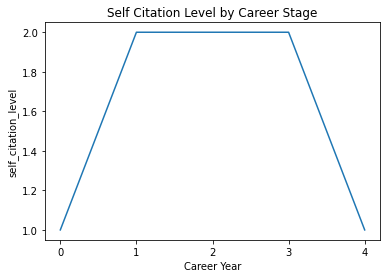

In [ ]:
by_career_stage_df, by_career_stage_fig = x.plot_by_career_stage()